# Development Notebook for Cortical Crowding Project

## Dependencies

In [1]:
import os, sys
from pathlib import Path

import numpy as np
import pandas as pd
import neuropythy as ny
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.optimize
from scipy.stats import gmean
from scipy.optimize import curve_fit

/home/lindazelinzhou/.conda/envs/neuro/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# We want to be able to load in libraries that are in this repository's src directory,
# so we add src to the system path:
try:
    import corticalcrodwing as cc
except ModuleNotFoundError:
    # This probably happens because the corticalcrowding library hasn't been
    # installed yet; we can add the src directory to the path to work around
    # this here.
    sys.path.append('../src')
    # Now we can import corticalcrowding from the src directory:
    import corticalcrowding as cc

## Configuration

In [3]:
# The root path where data is stored:
data_path = Path('/data/crowding')

# The crowding data CSV file:
crowding_data_filename = data_path / 'crowding_data_withID.csv'

In [4]:
# The list of subjects:
sids_NYU = [
    'sub-wlsubj070',
    'sub-wlsubj114',
    'sub-wlsubj121',
    'sub-wlsubj135']
sids_NEI = [ 
    'sub-wlsubj119',
    'sub-wlsubj127',
    'sub-wlsubj136',
    'sub-wlsubj137',
    'sub-wlsubj143',
    'sub-wlsubj144',
    'sub-wlsubj145',
    'sub-wlsubj146',
    'sub-wlsubj147',
    'sub-wlsubj148',
    'sub-wlsubj149',
    'sub-wlsubj150',
    'sub-wlsubj151',
    'sub-wlsubj152',
    'sub-wlsubj153',
    'sub-wlsubj154',
    'sub-wlsubj155',
    'sub-wlsubj156',
    'sub-wlsubj157',
    'sub-wlsubj158',
    'sub-wlsubj159',
    'sub-wlsubj160',
    'sub-wlsubj161',
    'sub-wlsubj162',
    'sub-wlsubj163',
    'sub-wlsubj164',
    'sub-wlsubj165',
    'sub-wlsubj166',
    'sub-wlsubj167',
    'sub-wlsubj168',
    'sub-wlsubj170',
    'sub-wlsubj171',
    'sub-wlsubj172',
    'sub-wlsubj173',
    'sub-wlsubj174',
    'sub-wlsubj175',
    'sub-wlsubj176']

sids_orig = sids_NYU + sids_NEI

## Import Data

In [74]:
crowding_data = pd.read_csv(crowding_data_filename)

,ID,FlankinDirection,Eccen_X,Eccen_Y,CrowdingDistance,Session,RadialEccentricity
0,sub-wlsubj153,radial,5.0,0.0,3.701109,1,5.0
1,sub-wlsubj153,radial,-5.0,-0.0,2.805407,1,5.0
2,sub-wlsubj153,radial,0.0,5.0,3.498309,1,5.0
3,sub-wlsubj153,radial,-0.0,-5.0,2.551906,1,5.0
4,sub-wlsubj153,radial,10.0,0.0,7.250118,1,10.0
...,...,...,...,...,...,...,...
475,sub-wlsubj005,radial,-0.0,-5.0,1.487204,2,5.0
476,sub-wlsubj005,radial,2.5,0.0,0.439401,2,2.5
477,sub-wlsubj005,radial,-2.5,-0.0,0.659102,2,2.5
478,sub-wlsubj005,radial,0.0,2.5,0.760502,2,2.5


## Crowding Distance Calculations

In [6]:
# merge the 2 sessions, so now each sub have 12 cd (match with polar angle) instead of 24
mean_cd_polar = (
    crowding_data
    .groupby(['ID','Eccen_X','Eccen_Y'])
    ['CrowdingDistance']
    .apply(gmean)
    .reset_index())

In [7]:
# each subject has 1 cd value at each eccentricity
mean_cd = (
    crowding_data
    .groupby(['ID','RadialEccentricity'])
    ['CrowdingDistance']
    .apply(gmean)
    .reset_index())

In [8]:
cd_list = crowding_data['CrowdingDistance'].tolist()
mean_cd_list = mean_cd['CrowdingDistance'].tolist()

In [9]:
# create 3 dfs based on the eccentricities in the dataframe:
crowding_eccens = np.unique(crowding_data['RadialEccentricity'])
assert len(crowding_eccens) == 3
(ecc_1, ecc_2, ecc_3) = crowding_eccens

mean_1 = mean_cd[mean_cd['RadialEccentricity'] == ecc_1]
n_1 = len(mean_1)
m_1 = mean_1['CrowdingDistance'].mean()
st_1 = mean_1['CrowdingDistance'].std()

mean_2 = mean_cd[mean_cd['RadialEccentricity'] == ecc_2]
n_2 = len(mean_2)
m_2 = mean_2['CrowdingDistance'].mean()
st_2 = mean_2['CrowdingDistance'].std()

mean_3 = mean_cd[mean_cd['RadialEccentricity'] == ecc_3]
n_3 = len(mean_3)
m_3 = mean_3['CrowdingDistance'].mean()
st_3 = mean_3['CrowdingDistance'].std()

In [10]:
x_ecc = crowding_data['RadialEccentricity'].tolist()
mean_x_ecc = mean_cd['RadialEccentricity'].tolist()

In [139]:
# The crowding distance function in terms of eccentricity function described
# by Kurzawski et al. (2023):
Kurzawski2023_cd = cc.crowding.Kurzawski2023_cd
# We wrap this with a log10 so that we can fit using log errors.
def log_Kurzawski2023_cd(x, b):
    return np.log10(Kurzawski2023_cd(x, b))

# Fit the b parameter using this function by minimizing log error.
b, _ = curve_fit(log_Kurzawski2023_cd, x_ecc, np.log10(cd_list), p0=0.15)
b = b[0]
b

0.19811346275888986

In [13]:
mean_values = [m_1, m_2, m_3]
std_values = [st_1, st_2, st_3]
sem_values = np.array([st_1, st_2, st_3]) / np.sqrt([n_1, n_2, n_3])
eccentricities = [ecc_1, ecc_2, ecc_3]

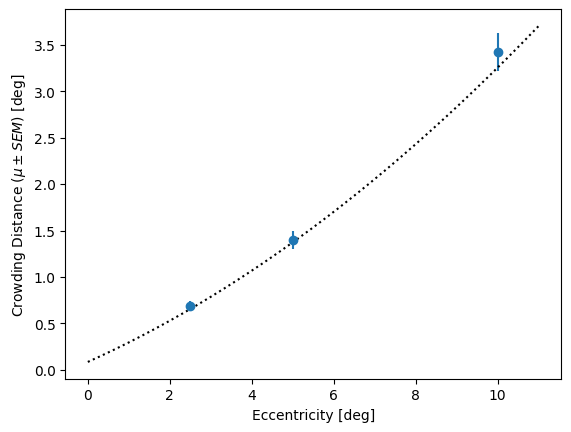

In [14]:
plt.errorbar(eccentricities, mean_values, sem_values, fmt='o')
plt.gca().set_xlabel('Eccentricity [deg]')
plt.gca().set_ylabel(r'Crowding Distance $(\mu \pm SEM)$ [deg]')
x = np.linspace(0,11,500)
y = Kurzawski2023_cd(x, b)
plt.gca().plot(x, y, 'k:')
plt.show()

### bootstrap on crowding distance fit

In [182]:
num_bootstrap_samples = 1000
x = np.linspace(0.5,11,1000)
eccentricities = [2.5, 5, 10]

# sid_df.shape=(480,)
sid_df = crowding_data['ID'].values
x_ecc = np.array(x_ecc)
cd = np.array(cd_list)

def bootstrap_fit(sids, xdata, ydata, x):
    # unique_sids : 20 numbers
    unique_sids = np.unique(sids)
    bootstrapped_parameters = []
    for _ in range(num_bootstrap_samples):
        # each bootstrap, sample 20 subjects with replacement
        indices = np.random.choice(unique_sids, size=len(unique_sids), replace=True)
        indices = [np.where(sids == sid)[0] for sid in indices]
        indices = [k for ak in indices for k in ak]
        # 20 by 24 = 480, 480 x values and y values each
        x_boot = xdata[indices]
        y_boot = ydata[indices]
        # Fit the curve to the bootstrapped sample
        b, _ = curve_fit(log_Kurzawski2023_cd, x_boot, np.log10(y_boot), p0=0.15)
        y = (0.43 + x + 0.06*(x**2)) * b
        bootstrapped_parameters.append(y) 
    return bootstrapped_parameters

bootstrapped = bootstrap_fit(sid_df, x_ecc, cd, x)

# Calculate confidence interval
confidence_interval_cd = np.percentile(bootstrapped, [2.5, 97.5], axis=0)

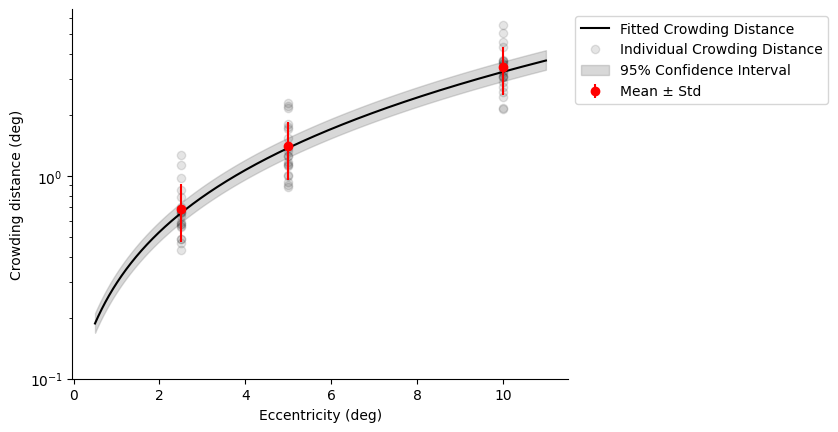

In [183]:
x = np.linspace(0.5, 11, 1000)
# Fitted value without bootstrap
plt.plot(x, (0.43 + x + 0.06*(x**2)) * b, 'k-', label='Fitted Crowding Distance')

# Plot individual data
plt.plot(mean_x_ecc, mean_cd_list, 'ko', alpha=0.1, label='Individual Crowding Distance')

# Plot error bars
plt.errorbar(eccentricities, mean_values, yerr=std_values, fmt='o', color='red', label='Mean ± Std')
plt.fill_between(x, confidence_interval_cd[0], confidence_interval_cd[1], color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Eccentricity (deg)')
plt.ylabel('Crowding distance (deg)')
plt.yscale('log')
plt.ylim(bottom=0.1)  # Set lower limit to 0.1 (10^-1)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


## Fit Cortical Magnification

In [15]:
eccen = np.linspace(1, 11, 1000)

In [16]:
def cmag_basics(sid, h, label,
                minecc=0, maxecc=12,
                mincod=0.04):
    """Loads the basic cortical magnification data for a subject and returns it.
    
    The data is returned as ``(ecc, srf)`` where ``ecc`` is the eccentricity values
    and ``srf`` is the surface area values within the given visual area.
    """
    sub = cc.cmag.load_subject(sid)
    hem = sub.hemis[h]
    mask_nocod = {
        'and': [
            ('eccentricity', minecc, maxecc),
            ('visual_area', label)]}
    mask_cod = {'and': mask_nocod['and'] + [('variance_explained', mincod, 1)]}
    rdat = ny.retinotopy_data(hem)
    mask_ii = hem.mask(mask_cod)
    ecc = rdat['eccentricity'][mask_ii]
    srf = hem.prop('midgray_surface_area')
    totarea = np.sum(srf[hem.mask(mask_nocod)])
    srf = srf[mask_ii]
    ii = np.argsort(ecc)
    ecc = ecc[ii]
    srf = srf[ii] * totarea / np.sum(srf)
    return (ecc, srf)

$$ c_1 = \sqrt{\frac{a_M}{\pi \left(\log\left(\frac{c_2 + M}{c_2}\right) - \frac{M}{c_2 + M}\right)}} $$

In [17]:
def fit_cumarea(sid, h, label,
                params0=(17.3, 0.75), fix_gain=False, method=None):
    """Given a subject, hemisphere, and label, fit the Horton and Hoyt (1991)
    cortical magnification function to the retinotopic mapping data using the
    method of cumulative area.
    """
    (ecc,srf) = cmag_basics(sid, h, label)
    if len(ecc) == 0:
        raise RuntimeError(f"no data found for {sid}:{h}:{label}")
    r = cc.cmag.HH91_fit_cumarea(
        ecc, srf,
        params0=params0,
        fix_gain=fix_gain,
        method=method)
    return r

In [18]:
df = dict(sid=[], h=[], label=[], a=[], b=[], loss=[])
for sid in sids_orig:
    print(sid)
    for h in ['lh','rh']:
        for lbl in [1,2,3,4]:
            try:
                r = fit_cumarea(sid, h, lbl)
            except Exception as e:
                print(f"  - Skipping: {type(e)}")
                continue
            df['sid'].append(sid)
            df['h'].append(h)
            df['label'].append(lbl)
            df['a'].append(r.x[0])
            df['b'].append(r.x[1])
            df['loss'].append(r.fun)
HH91_params = pd.DataFrame(df)

sub-wlsubj070
sub-wlsubj114
sub-wlsubj121
sub-wlsubj135
sub-wlsubj119
sub-wlsubj127
sub-wlsubj136
sub-wlsubj137
sub-wlsubj143
sub-wlsubj144
sub-wlsubj145
sub-wlsubj146
sub-wlsubj147
sub-wlsubj148
sub-wlsubj149
sub-wlsubj150
sub-wlsubj151
sub-wlsubj152
sub-wlsubj153
sub-wlsubj154
sub-wlsubj155
sub-wlsubj156
sub-wlsubj157
sub-wlsubj158
sub-wlsubj159
sub-wlsubj160
sub-wlsubj161
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
  - Skipping: <class 'ValueError'>
sub-wlsubj162
sub-wlsubj163
sub-wlsubj164
sub-wlsubj165
sub-wlsubj166
sub-wlsubj167
sub-wlsubj168
sub-wlsubj170
sub-wlsubj171
sub-wlsubj172
sub-wlsubj173
sub-wlsubj174
sub-wlsubj175
sub-wlsubj176


### Histogram of the `a` parameter (gain)

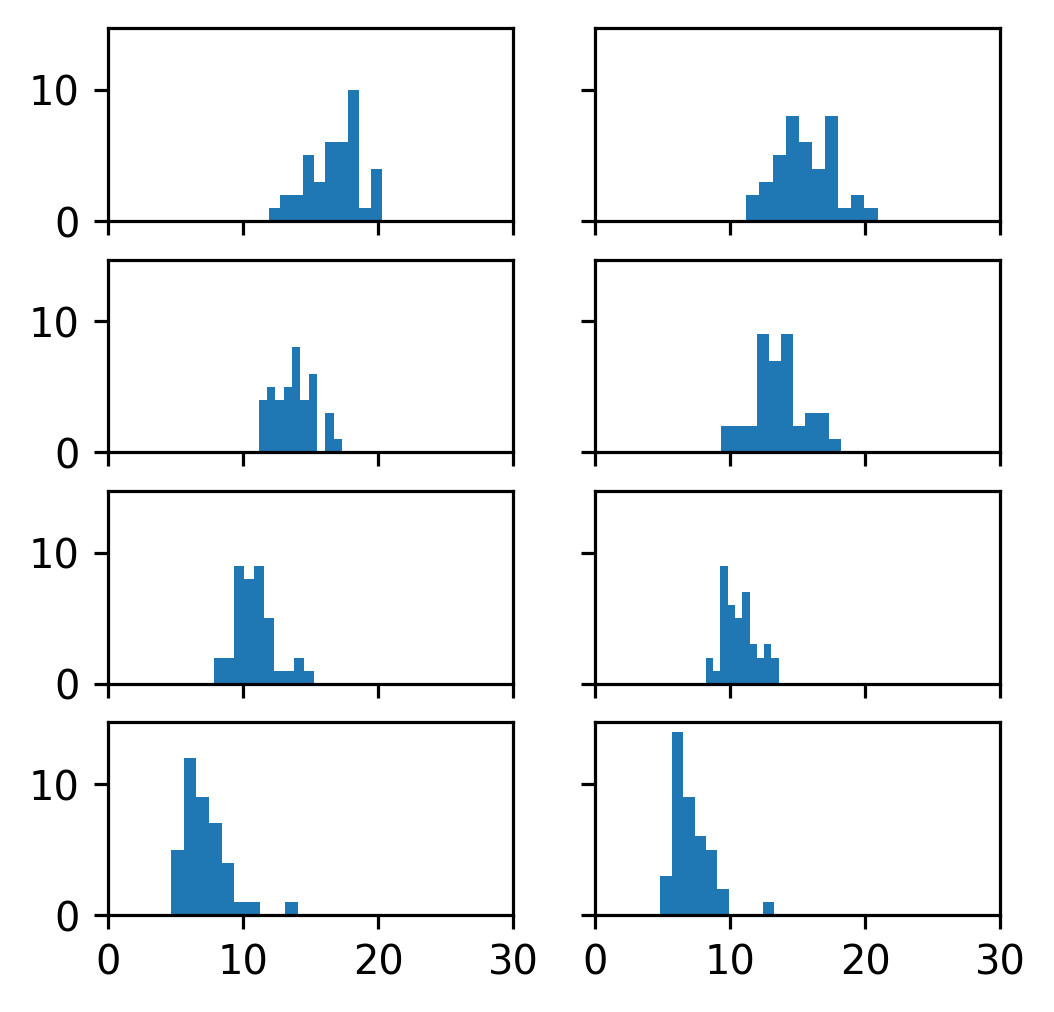

In [19]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        q = df2['a'].values
        ax.hist(q)
        ax.set_xlim([0,30])

### Histogram of the `b` parameter (shape)

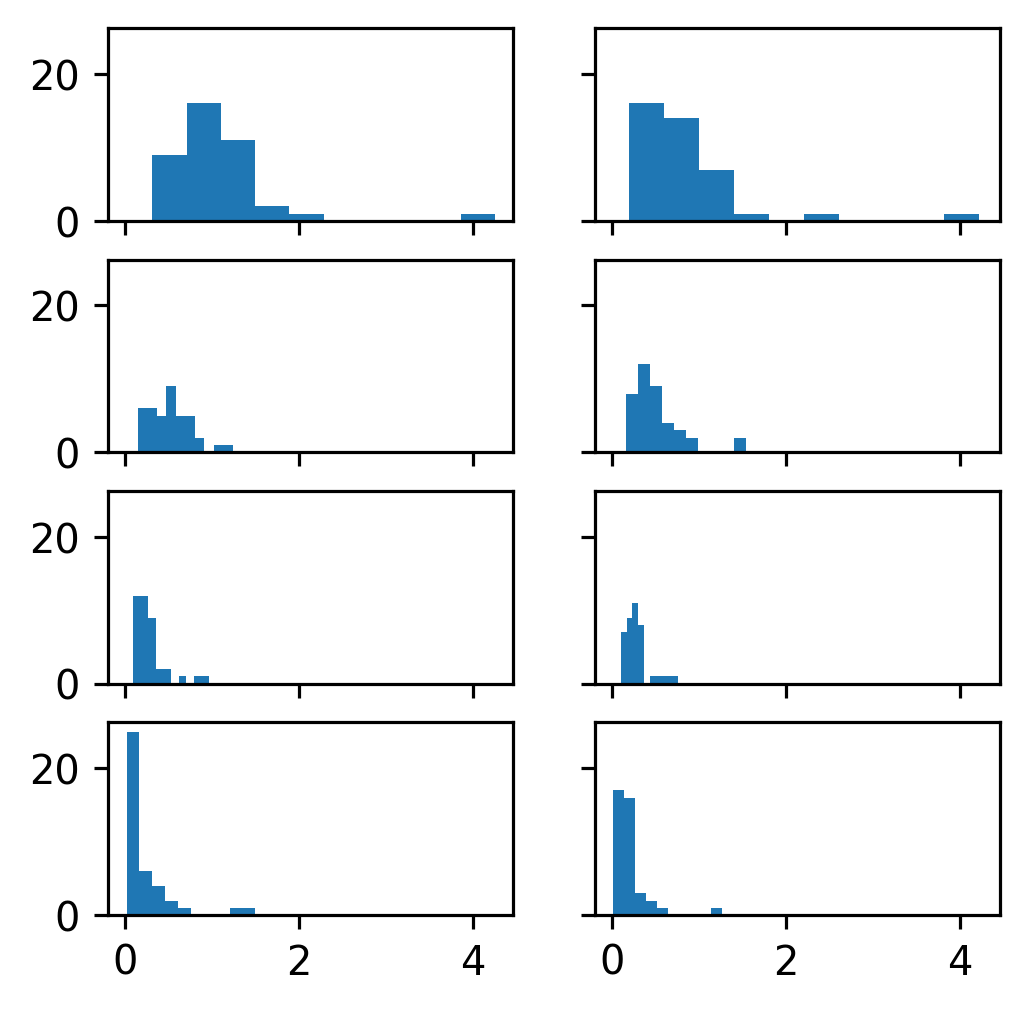

In [20]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        q = df2['b'].values
        ax.hist(q)
        #ax.set_xlim([0,2])

### plot hh91 fit vs eccentricity

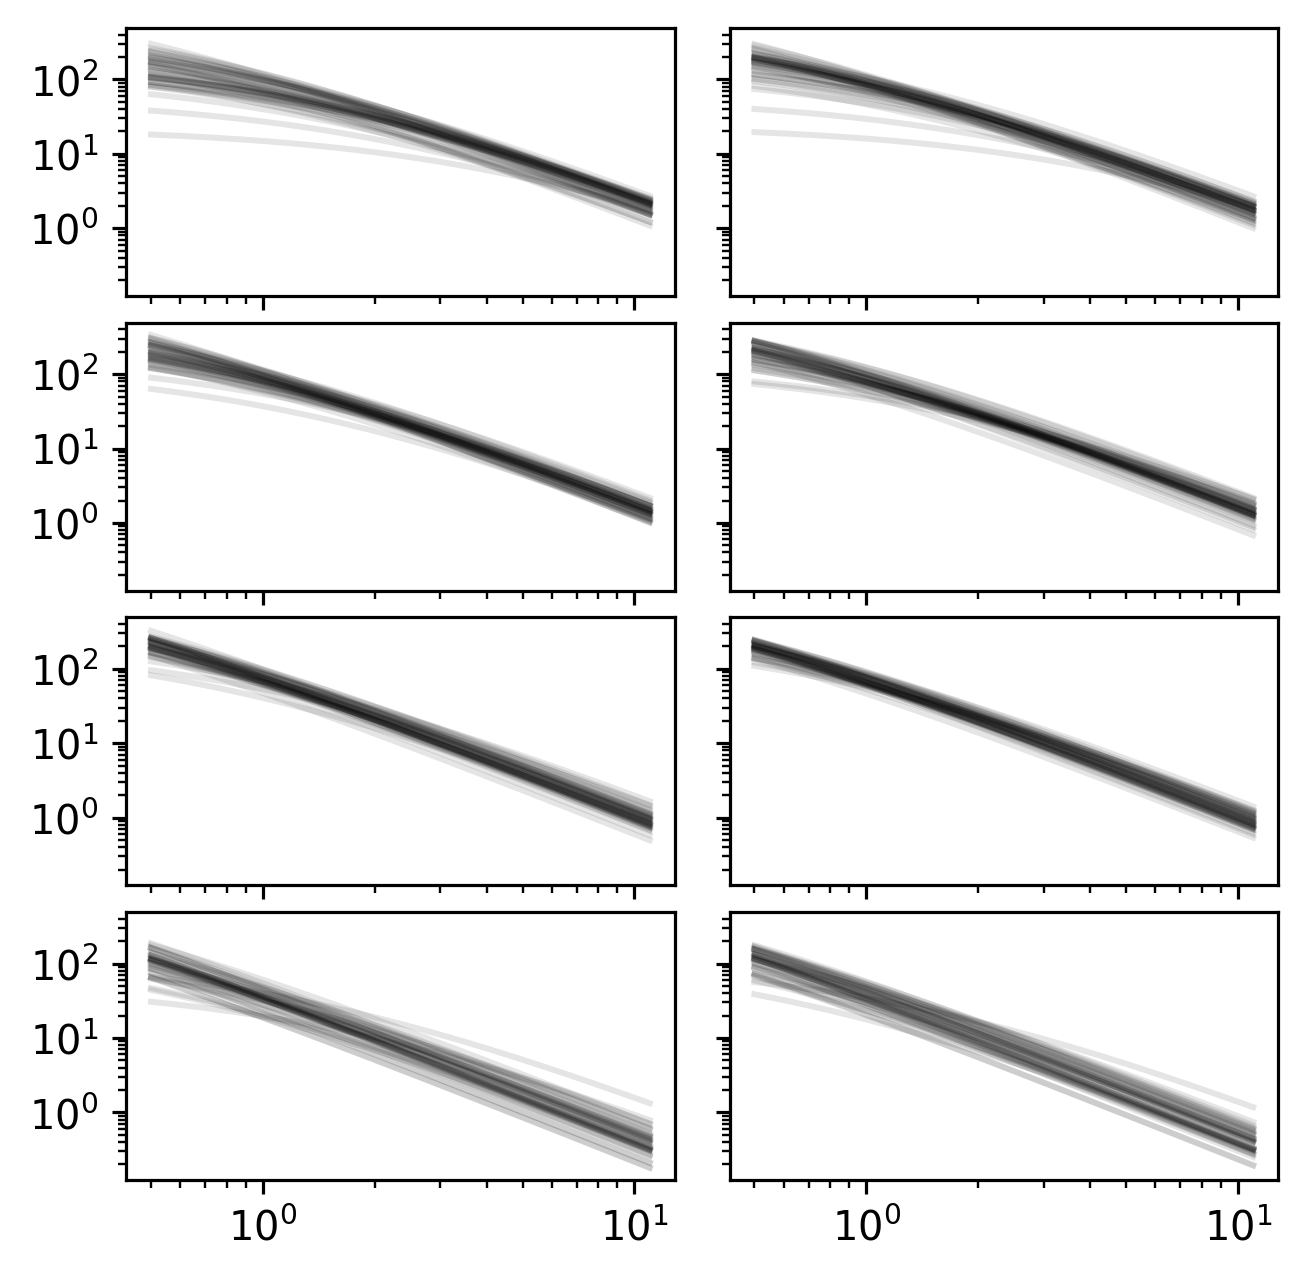

In [21]:
df = HH91_params
(fig,axs) = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
fig.subplots_adjust(0,0,1,1,0.1,0.1)
eccrng = np.linspace(0.5, 11, 500)
for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        for (a,b) in zip(df2['a'].values, df2['b'].values):
            ax.loglog(eccrng, (a / (b + eccrng))**2, 'k-', alpha=0.1)

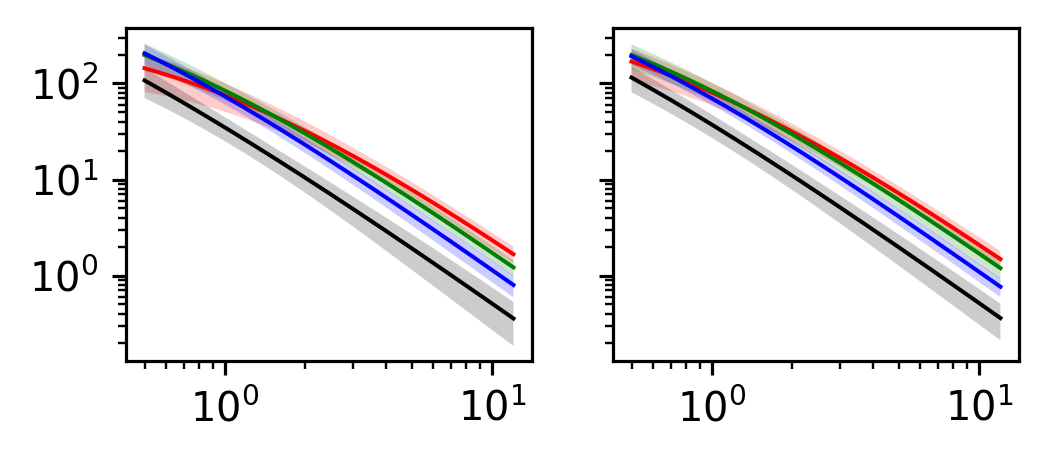

In [22]:
df = HH91_params
(fig,axs) = plt.subplots(1,2, figsize=(4,1.5), dpi=288, sharex=True, sharey=True)
eccrng = np.linspace(0.5, 12, 500)
for (lbl,clr) in zip([1,2,3,4], ['r','g','b','k']):
    df1 = df[df['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axs):
        df2 = df1[df1['h'] == h]
        a = df2['a'].values
        b = df2['b'].values
        m = (a[:,None] / (b[:,None] + eccrng[None,:]))**2
        mu = np.mean(m, axis=0)
        sd = np.std(m, axis=0)
        ax.fill_between(eccrng, mu - sd, mu + sd, edgecolor=None, facecolor=clr, alpha=0.2, zorder=-1)
        ax.loglog(eccrng, mu, clr+'-', lw=1)

### bootstrap on C.Mag fits and replot the C.Mag plot (similar to the one above) using confidence interval

In [184]:
x = np.linspace(0.5, 11, 1000)

In [109]:
mean_params = HH91_params.groupby('label')[['a', 'b']].mean().reset_index()

,label,a,b
0,1,16.185648,0.949919
1,2,13.685914,0.521892
2,3,10.796593,0.283868
3,4,7.197155,0.217300


In [110]:
cmag_per_label = {}

# fitted Cmag for each area
for _, row in mean_params.iterrows():
    label = row['label']
    a = row['a']
    b = row['b']
    cmag_r = (a / (b + x))**2
    cmag_per_label[label] = cmag_r


In [185]:
num_bootstrap_samples = 1000

bootstrap_cmag_per_label = {}

for lbl in [1,2,3,4]:
    df_lbl = HH91_params[HH91_params['label']==lbl]
    a_values = df_lbl['a'].values
    b_values = df_lbl['b'].values

    # Subjects added to keep track
    sids = df_lbl['sid'].values

    boot_curves = []
    n = len(a_values)

    for _ in range(num_bootstrap_samples):
        indices = np.random.choice(n, size=n, replace=True)
        mean_a = np.mean(a_values[indices])
        mean_b = np.mean(b_values[indices])

        # cmag curve
        cmag_boot = (mean_a / (mean_b + x))**2
        boot_curves.append(cmag_boot)

    # shape (1000, 1000)
    boot_curves = np.array(boot_curves)
    bootstrap_cmag_per_label[lbl] = boot_curves


In [198]:
bootstrapped_v1 = bootstrap_cmag_per_label[1]
bootstrapped_v2 = bootstrap_cmag_per_label[2]
bootstrapped_v3 = bootstrap_cmag_per_label[3]
bootstrapped_v4 = bootstrap_cmag_per_label[4]

In [199]:
confidence_interval_v1 = np.percentile(bootstrapped_v1, [2.5, 97.5], axis=0)
confidence_interval_v2 = np.percentile(bootstrapped_v2, [2.5, 97.5], axis=0)
confidence_interval_v3 = np.percentile(bootstrapped_v3, [2.5, 97.5], axis=0)
confidence_interval_v4 = np.percentile(bootstrapped_v4, [2.5, 97.5], axis=0)

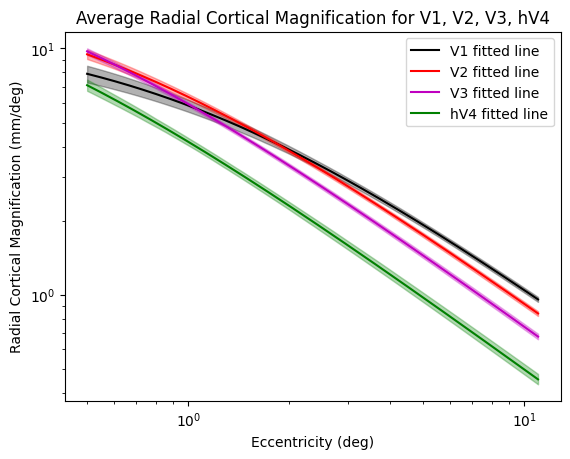

In [200]:
fig, ax = plt.subplots(1,1)

# Plotting the fitted lines for each visual area
ax.plot(x, np.sqrt(cmag_per_label[1]/2), 'k', label='V1 fitted line')
ax.plot(x, np.sqrt(cmag_per_label[2]/2), 'r', label='V2 fitted line')
ax.plot(x, np.sqrt(cmag_per_label[3]/2), 'm', label='V3 fitted line')
ax.plot(x, np.sqrt(cmag_per_label[4]/2), 'g', label='hV4 fitted line')

# Plotting the confidence intervals for each visual area
ax.fill_between(x, 
                 np.sqrt(confidence_interval_v1[0]/2),
                 np.sqrt(confidence_interval_v1[1]/2),
                 color='k', alpha=0.3)
ax.fill_between(x, 
                 np.sqrt(confidence_interval_v2[0]/2),
                 np.sqrt(confidence_interval_v2[1]/2),
                 color='r', alpha=0.3)
ax.fill_between(x, 
                 np.sqrt(confidence_interval_v3[0]/2),
                 np.sqrt(confidence_interval_v3[1]/2),
                 color='m', alpha=0.3)
ax.fill_between(x, 
                 np.sqrt(confidence_interval_v4[0]/2),
                 np.sqrt(confidence_interval_v4[1]/2),
                 color='g', alpha=0.3)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Eccentricity (deg)")
ax.set_ylabel("Radial Cortical Magnification (mm/deg)")
ax.set_title("Average Radial Cortical Magnification for V1, V2, V3, hV4")
ax.legend()
plt.show()

### cortical crowding distance (ccd) and coefficent of variation for ccd

In [205]:
bootstrapped_ccd_1 = []
bootstrapped_ccd_2 = []
bootstrapped_ccd_3 = []
bootstrapped_ccd_4 = []

# Iterate through 1000 bootstrapped samples
for i in range(1000):
    ccd_v1 = bootstrapped[i] * np.sqrt(bootstrapped_v1[i] / 2)
    bootstrapped_ccd_1.append(ccd_v1)
    
    ccd_v2 = bootstrapped[i] * np.sqrt(bootstrapped_v2[i] / 2)
    bootstrapped_ccd_2.append(ccd_v2)
    
    ccd_v3 = bootstrapped[i] * np.sqrt(bootstrapped_v3[i] / 2)
    bootstrapped_ccd_3.append(ccd_v3)
    
    ccd_v4 = bootstrapped[i] * np.sqrt(bootstrapped_v4[i] / 2)
    bootstrapped_ccd_4.append(ccd_v4)

bootstrapped_ccd_1 = np.array(bootstrapped_ccd_1)
bootstrapped_ccd_2 = np.array(bootstrapped_ccd_2)
bootstrapped_ccd_3 = np.array(bootstrapped_ccd_3)
bootstrapped_ccd_4 = np.array(bootstrapped_ccd_4)

# Calculate the mean of bootstrapped CCD values for each visual area
ccd1 = np.mean(bootstrapped_ccd_1, axis=0)
ccd2 = np.mean(bootstrapped_ccd_2, axis=0)
ccd3 = np.mean(bootstrapped_ccd_3, axis=0)
ccd4 = np.mean(bootstrapped_ccd_4, axis=0)

# Calculate the confidence interval for bootstrapped CCD values for each visual area
confidence_interval_ccd_1 = np.percentile(bootstrapped_ccd_1,  [16, 84], axis=0)
confidence_interval_ccd_2 = np.percentile(bootstrapped_ccd_2,  [16, 84], axis=0)
confidence_interval_ccd_3 = np.percentile(bootstrapped_ccd_3,  [16, 84], axis=0)
confidence_interval_ccd_4 = np.percentile(bootstrapped_ccd_4,  [16, 84], axis=0)

In [206]:
# Calculate the coefficient of variation for ccd_1
mean_ccd_1 = np.mean(ccd1)
std_ccd_1 = np.std(ccd1)
cv_ccd_1 = std_ccd_1 / mean_ccd_1
rounded_cv_ccd_1 = round(cv_ccd_1, 2)

print("Coefficient of Variation (CCD 1):", rounded_cv_ccd_1)

# Calculate the coefficient of variation for ccd_2
mean_ccd_2 = np.mean(ccd2)
std_ccd_2 = np.std(ccd2)
cv_ccd_2 = std_ccd_2 / mean_ccd_2
rounded_cv_ccd_2 = round(cv_ccd_2, 2)
print("Coefficient of Variation (CCD 2):", rounded_cv_ccd_2)

# Calculate the coefficient of variation for ccd_3
mean_ccd_3 = np.mean(ccd3)
std_ccd_3 = np.std(ccd3)
cv_ccd_3 = std_ccd_3 / mean_ccd_3
rounded_cv_ccd_3 = round(cv_ccd_3, 2)
print("Coefficient of Variation (CCD 3):", rounded_cv_ccd_3)

# Calculate the coefficient of variation for ccd_4
mean_ccd_4 = np.mean(ccd4)
std_ccd_4 = np.std(ccd4)
cv_ccd_4 = std_ccd_4 / mean_ccd_4
rounded_cv_ccd_4 = round(cv_ccd_4, 2)
print("Coefficient of Variation (CCD 4):", rounded_cv_ccd_4)

Coefficient of Variation (CCD 1): 0.2
Coefficient of Variation (CCD 2): 0.15
Coefficient of Variation (CCD 3): 0.11
Coefficient of Variation (CCD 4): 0.1


In [213]:
def bootstrap_cv(data, num_samples=1000):
    bootstrapped_cv = []
    n = len(data)
    for _ in range(num_samples):
        sample_indices = np.random.choice(n, size=n, replace=True)
        bootstrapped_sample = data[sample_indices]
        mean_sample = np.mean(bootstrapped_sample)
        std_sample = np.std(bootstrapped_sample)
        cv_sample = std_sample / mean_sample
        bootstrapped_cv.append(cv_sample)
    return np.array(bootstrapped_cv)

bootstrapped_cv_1 = bootstrap_cv(ccd1)
ci_1 = np.percentile(bootstrapped_cv_1, [2.5, 97.5])

bootstrapped_cv_2 = bootstrap_cv(ccd2)
ci_2 = np.percentile(bootstrapped_cv_2, [2.5, 97.5])

bootstrapped_cv_3 = bootstrap_cv(ccd3)
ci_3 = np.percentile(bootstrapped_cv_3, [2.5, 97.5])

bootstrapped_cv_4 = bootstrap_cv(ccd4)
ci_4 = np.percentile(bootstrapped_cv_4, [2.5, 97.5])

In [214]:
cv_ccd_1 = bootstrapped_cv_1.mean()
cv_ccd_2 = bootstrapped_cv_2.mean()
cv_ccd_3 = bootstrapped_cv_3.mean()
cv_ccd_4 = bootstrapped_cv_4.mean()
print([cv_ccd_1, cv_ccd_2, cv_ccd_3, cv_ccd_4])

[0.1987442695548461, 0.14886055478334206, 0.11475789099525578, 0.10451847960841848]


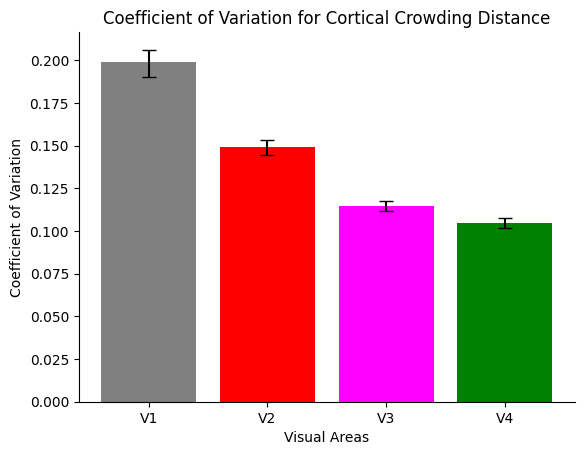

In [204]:
cv_ccd_values = [cv_ccd_1, cv_ccd_2, cv_ccd_3, cv_ccd_4]
ccd_labels = ['V1', 'V2', 'V3', 'V4']
cv_ci_list = [(ci_1[0], ci_1[1]), (ci_2[0], ci_2[1]), (ci_3[0], ci_3[1]),(ci_4[0], ci_4[1])]

lower_bound = [ci[0] for ci in cv_ci_list]
upper_bound = [ci[1] for ci in cv_ci_list]

yerr = [[cv_ccd_values[i] - lower_bound[i] for i in range(len(cv_ccd_values))],
        [upper_bound[i] - cv_ccd_values[i] for i in range(len(cv_ccd_values))]]

plt.bar(ccd_labels, cv_ccd_values, yerr=yerr, capsize=5, color=['grey', 'red', 'magenta', 'green'])

plt.xlabel('Visual Areas')
plt.ylabel('Coefficient of Variation')
plt.title('Coefficient of Variation for Cortical Crowding Distance')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


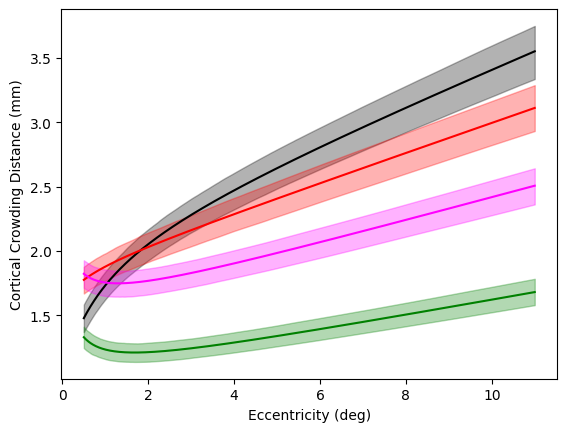

In [209]:
# plot the mean cortical crowding distance of each area
plt.plot(x, ccd1, label='Cortical crowding distance in V1', color='black')
plt.plot(x, ccd2, label='Cortical crowding distance in V2', color='red')
plt.plot(x, ccd3, label='Cortical crowding distance in V3', color='magenta')
plt.plot(x, ccd4, label='Cortical crowding distance in hV4', color='green')

plt.fill_between(x, confidence_interval_ccd_1[0], confidence_interval_ccd_1[1], color='black', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_2[0], confidence_interval_ccd_2[1], color='red', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_3[0], confidence_interval_ccd_3[1], color='magenta', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_4[0], confidence_interval_ccd_4[1], color='green', alpha=0.3)

plt.xlabel('Eccentricity (deg)')
plt.ylabel('Cortical Crowding Distance (mm)')
plt.show()

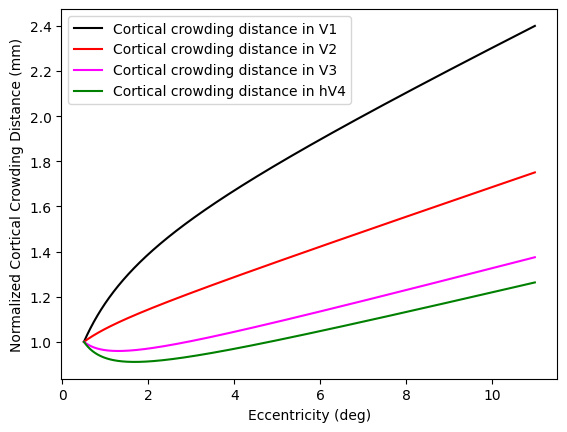

In [210]:
plt.plot(x, ccd1/ccd1[0], label='Cortical crowding distance in V1', color='black')
plt.plot(x, ccd2/ccd2[0], label='Cortical crowding distance in V2', color='red')
plt.plot(x, ccd3/ccd3[0], label='Cortical crowding distance in V3', color='magenta')
plt.plot(x, ccd4/ccd4[0], label='Cortical crowding distance in hV4', color='green')

plt.xlabel('Eccentricity (deg)')
plt.ylabel('Normalized Cortical Crowding Distance (mm)')
#plt.xticks([2.5, 5, 10])
plt.legend()
plt.show()

## have two dfs of fitted cortical magnification and crowding values based on VM/HM

In [23]:
# merge the 2 sessions, so now each sub have 12 cd (match with polar angle) instead of 24
# mean_cd_polar = df.groupby(['ID','Eccen_X','Eccen_Y'])['CrowdingDistance'].apply(gmean).reset_index()
mean_cd_polar

,ID,Eccen_X,Eccen_Y,CrowdingDistance
0,sub-wlsubj001,-10.0,0.0,3.757971
1,sub-wlsubj001,-5.0,0.0,1.905962
2,sub-wlsubj001,-2.5,0.0,0.777402
3,sub-wlsubj001,0.0,-10.0,4.115811
4,sub-wlsubj001,0.0,-5.0,1.917689
...,...,...,...,...
235,sub-wlsubj158,0.0,5.0,1.284848
236,sub-wlsubj158,0.0,10.0,3.560097
237,sub-wlsubj158,2.5,0.0,0.329442
238,sub-wlsubj158,5.0,0.0,0.828792


In [24]:
# only look at horizontal meridian for crowding_hrz
# h is assigned 'lh' for x values larger than 0 and 'rh' otherwise
crowding_hrz = mean_cd_polar[mean_cd_polar['Eccen_Y'] == 0].copy()
x = crowding_hrz['Eccen_X'].values
# for calculating cmag, have a col for abs(x)
crowding_hrz['eccen'] = np.abs(x)
crowding_hrz['h'] = np.where(x > 0, 'lh', 'rh')
crowding_hrz.rename(columns={'CrowdingDistance': 'CrowdingDistance_HM'}, inplace=True)
crowding_hrz.rename(columns={'ID': 'sid'}, inplace=True)

In [26]:
# only look at vertical meridian for crowding_vrt
crowding_vrt = mean_cd_polar[mean_cd_polar['Eccen_X'] == 0].copy()
y = crowding_vrt['Eccen_Y'].values
crowding_vrt['eccen'] = np.abs(y)

# Create the 'CrowdingDistance_UVM' and 'CrowdingDistance_LVM' columns
crowding_vrt['CrowdingDistance_UVM'] = np.where(y > 0, np.nan, crowding_vrt['CrowdingDistance'])
crowding_vrt['CrowdingDistance_LVM'] = np.where(y > 0, crowding_vrt['CrowdingDistance'], np.nan)
crowding_vrt.rename(columns={'ID': 'sid'}, inplace=True)

In [27]:
# Create duplicate rows with 'h' column
crowding_vrt_lh = crowding_vrt.copy()
crowding_vrt_lh['h'] = 'lh'
crowding_vrt_rh = crowding_vrt.copy()
crowding_vrt_rh['h'] = 'rh'

# Combine the two DataFrames, so now crowding_vrt has two rows with same data except one row lh and one row rh
crowding_vrt = pd.concat([crowding_vrt_lh, crowding_vrt_rh], ignore_index=True)
crowding_vrt = crowding_vrt.drop(columns=['CrowdingDistance'])

In [28]:
df = HH91_params.copy()

# will have three rows for diff ecc, but the same a,b params
df = df.merge(
    pd.DataFrame(dict(eccen=[2.5, 5.0, 10.0])),
    how='cross')

a = df['a']
b = df['b']
ecc = df['eccen']
# calculate cmag based on a,b params from HH91_params
df['cmag_fit'] = (a / (ecc + b))**2
# add 1d visual magnification
df['vmag1d_fit'] = np.sqrt(1 / df['cmag_fit'])

# add CrowdingDistance_HM to df by merging it with crowding_hrz
# _full versions have x, y positions too
df_HM_full = df.merge(crowding_hrz, on=['sid', 'eccen','h'])
# 15 subs, 2 hemisphere * 3 ecc * 4 visual area = 360 rows
df_HM = df_HM_full.drop(columns=['Eccen_X', 'Eccen_Y'])

In [30]:
df_VM_full = df.merge(crowding_vrt, on=['sid', 'eccen','h'])
# 15 subs, 2 loc * 3 ecc * 4 visual area * 2h = 48
df_VM = df_VM_full.drop(columns=['Eccen_X', 'Eccen_Y'])

df_VM = df_VM.groupby(
    ['sid', 'label', 'eccen'], as_index=False
).agg({
    'a': 'mean',
    'b': 'mean',
    'loss': 'mean',
    'CrowdingDistance_UVM': 'mean', 
    'CrowdingDistance_LVM': 'mean', 
})

# compute cmag_fit based on a, b, and eccen
df_VM['cmag_fit'] = (df_VM['a'] / (df_VM['eccen'] + df_VM['b']))**2

# compute 1d_vmag_fit from cmag_fit
df_VM['vmag1d_fit'] = np.sqrt(1 / df_VM['cmag_fit'])

In [33]:
rename_VM = dict(
    a='a_VM', b='b_VM', loss='loss_VM',
    cmag_fit='cmag_fit_VM', vmag1d_fit='vmag1d_fit_VM')
rename_HM = dict(
    a='a_HM', b='b_HM', loss='loss_HM',
    cmag_fit='cmag_fit_HM', vmag1d_fit='vmag1d_fit_HM')

df = pd.merge(
    df_HM.rename(columns=rename_HM), df_VM.rename(columns=rename_VM),
    on=('sid', 'label', 'eccen'))

In [196]:
df

,sid,h,label,a_HM,b_HM,loss_HM,eccen,cmag_fit_HM,vmag1d_fit_HM,CrowdingDistance_HM,a_VM,b_VM,loss_VM,CrowdingDistance_UVM,CrowdingDistance_LVM,cmag_fit_VM,vmag1d_fit_VM
0,sub-wlsubj070,lh,1,16.615231,0.667592,8294.519038,2.5,27.514029,0.190644,0.478005,16.861346,0.929624,5625.230122,0.655626,0.657149,24.170823,0.203402
1,sub-wlsubj070,lh,1,16.615231,0.667592,8294.519038,5.0,8.594400,0.341108,0.750864,16.861346,0.929624,5625.230122,1.101489,1.573339,8.085933,0.351670
2,sub-wlsubj070,lh,1,16.615231,0.667592,8294.519038,10.0,2.425939,0.642037,1.774424,16.861346,0.929624,5625.230122,3.633352,4.636406,2.379984,0.648206
3,sub-wlsubj070,lh,2,15.469448,0.835027,6499.808295,2.5,21.515479,0.215588,0.478005,15.555412,0.839069,6363.691511,0.655626,0.657149,21.702626,0.214656
4,sub-wlsubj070,lh,2,15.469448,0.835027,6499.808295,5.0,7.028521,0.377197,0.750864,15.555412,0.839069,6363.691511,1.101489,1.573339,7.097017,0.375372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,sub-wlsubj158,rh,3,9.595558,0.184575,2931.708422,5.0,3.425422,0.540310,1.305139,10.365536,0.248601,1837.124306,1.157375,1.284848,3.900286,0.506351
356,sub-wlsubj158,rh,3,9.595558,0.184575,2931.708422,10.0,0.887676,1.061384,3.091969,10.365536,0.248601,1837.124306,3.434578,3.560097,1.022950,0.988719
357,sub-wlsubj158,rh,4,6.239073,0.056849,2023.291842,2.5,5.954292,0.409812,0.354498,6.430922,0.108665,1650.797081,0.642202,0.636618,6.077291,0.405644
358,sub-wlsubj158,rh,4,6.239073,0.056849,2023.291842,5.0,1.522230,0.810513,1.305139,6.430922,0.108665,1650.797081,1.157375,1.284848,1.584644,0.794391


# for each subject, each visual area, to have a fitted cortical crowding distance

In [40]:
def crowding_loss_notused(params, cd, cmags, position):
    '''
    position: 1 for horizontal, 2 for upper, 3 for lower
    params: d for cortical crowding distance, g_h, g_u, g_l
    cd: crowding distance
    cmags: cortical magnification
    '''
    gain = params[position] ** 2  # ensure that gain >= 0
    d = params[0]
    pred = d * np.sqrt(2/(gain*cmags))
    
    return np.sum((cd - pred)**2)

In [41]:
# preferred for now
def crowding_loss(params, cd, cmags, position):
    '''
    position: 1 for horizontal, 2 for upper, 3 for lower
    params: d, g_h, g_u, g_l
    cd: crowding distance
    cmags: cortical magnification
    '''
    gain = np.exp(params[position])
    d = params[0]
    pred = d * np.sqrt(2/(gain*cmags))
    
    return np.sum((cd - pred)**2)

In [42]:
def crowding_fit_data(df_HM, df_VM, sid, label):
    sub_hm = df_HM[(df_HM['label']==label) & (df_HM['sid']==sid)]
    cd_hm = sub_hm['CrowdingDistance_HM'].values
    cm_hm = sub_hm['cmag_fit'].values
    pos_hm = np.ones(len(cd_hm),dtype=int)
    
    sub_vm = df_VM[(df_VM['label']==label) & (df_VM['sid']==sid)]
    cd_um = sub_vm['CrowdingDistance_UVM'].values
    cd_lm = sub_vm['CrowdingDistance_LVM'].values
    cm_um = sub_vm['cmag_fit'].values
    cm_lm = sub_vm['cmag_fit'].values
    pos_um = np.ones(len(cd_um),dtype=int)*2
    pos_lm = np.ones(len(cd_lm),dtype=int)*3
    
    return(np.concatenate([cd_hm,cd_um,cd_lm]), np.concatenate([cm_hm,cm_um,cm_lm]), np.concatenate([pos_hm,pos_um,pos_lm]))

In [43]:
crowding_fit_data(df_HM, df_VM, 'sub-wlsubj158', 1) # 12 vals, 6+3+3, hm: lh*3, rh*3, vm: mean for 3 ecc

(array([0.32944247, 0.82879159, 1.87316215, 0.35449828, 1.30513853,
        3.09196887, 0.64220161, 1.15737531, 3.43457761, 0.63661811,
        1.28484788, 3.56009732]),
 array([16.13811947,  5.10566957,  1.45218851, 20.01590333,  5.92005614,
         1.61886052, 17.95191929,  5.49685037,  1.53347576, 17.95191929,
         5.49685037,  1.53347576]),
 array([1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3]))

In [ ]:
def crowding_fit_notused(df_HM, df_VM, sid, label, method = 'BFGS'):
    from scipy.optimize import minimize
    cd_cm = crowding_fit_data(df_HM, df_VM, sid, label)
    params0 = [1.5, np.sqrt(1), np.sqrt(1), np.sqrt(1)] 
    r = minimize(crowding_loss, params0, args=cd_cm, method=method)
    r.x[1] = r.x[1]**2
    r.x[2] = r.x[2]**2
    r.x[3] = r.x[3]**2
    return r

In [44]:
def crowding_fit(df_HM, df_VM, sid, label, method = 'BFGS'):
    from scipy.optimize import minimize
    cd_cm = crowding_fit_data(df_HM, df_VM, sid, label)
    params0 = [1.5, np.log(1), np.log(1), np.log(1)] 
    r = minimize(crowding_loss, params0, args=cd_cm, method=method)
    r.x[1] = np.exp(r.x[1])
    r.x[2] = np.exp(r.x[2])
    r.x[3] = np.exp(r.x[3])
    return r

In [45]:
df_fit = dict(sid=[], label=[], d=[], g_h=[], g_u=[], g_l=[], loss=[])
sids = np.unique(df_HM['sid'])
for sid in sids:
    for lbl in [1,2,3,4]:
        r = crowding_fit(df_HM, df_VM, sid, lbl)
        df_fit['sid'].append(sid)
        df_fit['label'].append(lbl)
        df_fit['d'].append(r.x[0])
        df_fit['g_h'].append(r.x[1])
        df_fit['g_u'].append(r.x[2])
        df_fit['g_l'].append(r.x[3])
        df_fit['loss'].append(r.fun)
    

In [ ]:
#df_fit_square = pd.DataFrame(df_fit)

In [46]:
df_fit_exp = pd.DataFrame(df_fit)

,sid,label,d,g_h,g_u,g_l,loss
0,sub-wlsubj070,1,2.669103,1.302244,0.589998,0.357928,2.966347
1,sub-wlsubj070,2,2.662293,1.496942,0.673247,0.408367,2.957751
2,sub-wlsubj070,3,2.756401,2.613994,1.188367,0.720033,2.065261
3,sub-wlsubj070,4,1.210940,2.242068,0.745851,0.451805,4.003183
4,sub-wlsubj114,1,2.969278,0.413748,0.367048,0.257054,1.731925
5,sub-wlsubj114,2,2.730946,0.441526,0.373681,0.261273,3.223213
6,sub-wlsubj114,3,2.476842,0.503252,0.432577,0.302294,2.856745
7,sub-wlsubj114,4,2.562190,1.084029,0.951569,0.661321,2.348211
8,sub-wlsubj119,1,2.850842,1.795141,1.035245,0.289162,2.085568
9,sub-wlsubj119,2,2.818328,2.057758,1.189091,0.330621,1.771014


In [47]:
df_fit_exp.groupby('label')['loss'].mean()

label
1    2.818739
2    2.362114
3    2.123117
4    2.486177
Name: loss, dtype: float64

In [60]:
df_fit_exp.groupby('label')['d'].mean()

label
1    2.686935
2    2.583455
3    2.339156
4    1.767641
Name: d, dtype: float64

In [49]:
HH91_params.groupby('label')['loss'].mean()

label
1    4890.628445
2    3229.211976
3    2518.227503
4    1722.607817
Name: loss, dtype: float64

In [216]:
def bootstrap_cv(data, num_samples=1000):
    bootstrapped_cv = []
    n = len(data)
    for _ in range(num_samples):
        sample_indices = np.random.choice(n, size=n, replace=True)
        bootstrapped_sample = data[sample_indices]
        mean_sample = np.mean(bootstrapped_sample)
        std_sample = np.std(bootstrapped_sample)
        cv_sample = std_sample / mean_sample
        bootstrapped_cv.append(cv_sample)
    return np.array(bootstrapped_cv)

In [215]:
df_fit_exp.groupby('label')['d'].std()/df_fit_exp.groupby('label')['d'].mean()

label
1    0.075266
2    0.082314
3    0.164281
4    0.321914
Name: d, dtype: float64

In [217]:
cv_values = []
ci_list = []

for label in [1,2,3,4]:
    data = df_fit_exp[df_fit_exp['label'] == label]['d'].values
    bootstrapped = bootstrap_cv(data)
    mean_cv = bootstrapped.mean()
    ci = np.percentile(bootstrapped, [2.5, 97.5])
    
    cv_values.append(mean_cv)
    ci_list.append(ci)


In [218]:
cv_values

[0.06686425572526059,
 0.07460715389790659,
 0.15233780397357366,
 0.29471115856420343]

In [69]:
lower_bounds = [ci[0] for ci in ci_list]
upper_bounds = [ci[1] for ci in ci_list]

yerr = [
    [mean_cv - lb for mean_cv, lb in zip(cv_values, lower_bounds)],
    [ub - mean_cv for mean_cv, ub in zip(cv_values, upper_bounds)]
]

labels = ['1', '2', '3', '4'] 


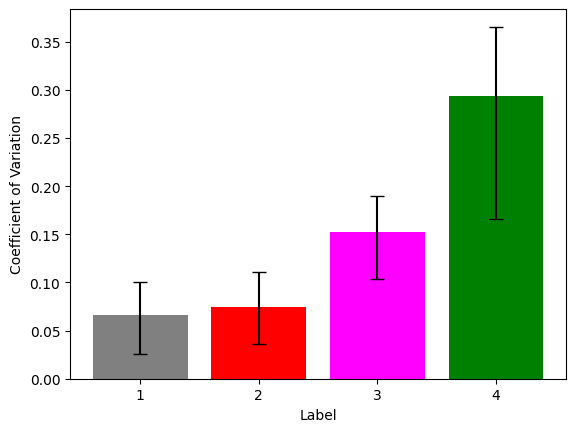

In [71]:
plt.bar(labels, cv_values, yerr=yerr, capsize=5, color=['grey', 'red', 'magenta', 'green'])
plt.xlabel('Label')
plt.ylabel('Coefficient of Variation')
plt.show()


In [ ]:
import seaborn as sns

In [ ]:
# exp
sns.violinplot(data=df_fit_exp,x='label',y='d',bw=0.15)

In [ ]:
sns.violinplot(data=df_fit_exp,x='label',y='loss',bw=0.15)

In [ ]:
# plots based on HM measurements
fig, axs = plt.subplots(4,2, figsize=(4,4), dpi=288, sharex=True, sharey=True)
fig.subplots_adjust(0,0,1,1,0.1,0.3)

for (lbl,axrow) in zip([1,2,3,4], axs):
    df1 = df_HM[df_HM['label'] == lbl]
    for (h,ax) in zip(['lh','rh'], axrow):
        df2 = df1[df1['h'] == h]
        loss = df2['loss']
        vmag = df2['1d_vmag_fit']
        cd = df2['CrowdingDistance_HM']
        eccen = df2['eccen']
        for (e,color) in zip([2.5,5,10],'rgb'):
            ii = (eccen==e)
            ax.scatter(vmag[ii], cd[ii], s=4*(2-loss[ii]/2000), c=color)
            ax.plot([0,2],[0,2],'k-')
            ax.set_title(f'{h} Label={lbl}', fontsize=6)
            
fig.text(0.5, -0.1, '1D Vmag Fit', ha='center', fontsize=8)
fig.text(-0.1, 0.5, 'Crowding Distance', va='center', rotation='vertical', fontsize=8)
plt.show()

## linear regression: predict crowding distance based on vmag_fit

In [ ]:
res = {1:[],2:[],3:[],4:[]}
for subject, subject_data in df_HM.groupby(['sid']):
    if (subject_data['b']>5).any():
        continue
    for h in ['lh','rh']:
        ssdf = subject_data[subject_data['h'] == h]
        for lbl in [1,2,3,4]:
            sssdf = ssdf[ssdf['label'] == lbl]
            x = sssdf['1d_vmag_fit'].values
            y = sssdf['CrowdingDistance_HM'].values
            (rss,coef) = cc.regression.fit_and_evaluate(x, y)
            res[lbl].append(rss)
            
print({k:np.mean(v) for (k,v) in res.items()})

In [ ]:
grouped = df_HM.groupby('sid') 
subject_results = {}

for subject, subject_data in grouped:
    if (subject_data['b']>5).any():
        continue
    subject_results[subject] = {}
    for h in ['lh', 'rh']:
        hemisphere_data = subject_data[subject_data['h'] == h]
        
        y1 = hemisphere_data[hemisphere_data['label'] == 1]['1d_vmag_fit'].values
        y2 = hemisphere_data[hemisphere_data['label'] == 2]['1d_vmag_fit'].values
        y3 = hemisphere_data[hemisphere_data['label'] == 3]['1d_vmag_fit'].values
        y4 = hemisphere_data[hemisphere_data['label'] == 4]['1d_vmag_fit'].values
        # since cd are the same for label 1,2,3,4
        y5 = hemisphere_data[hemisphere_data['label'] == 1]['CrowdingDistance_HM'].values
        
        rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
        rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
        rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
        rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)
        
        rss_values = [rss_y1, rss_y2, rss_y3, rss_y4]
        best_fit_index = np.argmin(rss_values)
        best_fit = ['label_1', 'label_2', 'label_3', 'label_4'][best_fit_index]
        
        subject_results[subject][h] = {
            'rss_label_1': rss_y1, 'coef_label_1': coef_y1,
            'rss_label_2': rss_y2, 'coef_label_2': coef_y2,
            'rss_label_3': rss_y3, 'coef_label_3': coef_y3,
            'rss_label_4': rss_y4, 'coef_label_4': coef_y4,
            'best_fit': best_fit
        }

for subject, hemispheres in subject_results.items():
    print(f"Results for {subject}:")
    for h, results in hemispheres.items():
        print(f"  Hemisphere: {h}")
        print(f"    RSS for label 1: {results['rss_label_1']}, Coefficient: {results['coef_label_1']}")
        print(f"    RSS for label 2: {results['rss_label_2']}, Coefficient: {results['coef_label_2']}")
        print(f"    RSS for label 3: {results['rss_label_3']}, Coefficient: {results['coef_label_3']}")
        print(f"    RSS for label 4: {results['rss_label_4']}, Coefficient: {results['coef_label_4']}")
        print(f"    The best fit is: {results['best_fit']}\n")


In [ ]:
rss_keys = ['rss_label_1', 'rss_label_2', 'rss_label_3', 'rss_label_4']

data = [[
    hemispheres[h][key]  
    for subject, hemispheres in subject_results.items()
    for h in ['lh', 'rh'] 
] for key in rss_keys]

plt.figure(figsize=(10, 6))
plt.hist(data, label=['Label 1', 'Label 2', 'Label 3', 'Label 4'])
plt.xlabel('RSS Values')
plt.ylabel('Frequency')
plt.title('Distribution of RSS Values for Each Label')
plt.legend()
plt.show()

In [ ]:
rss_label_1_values = []
rss_label_2_values = []
rss_label_3_values = []
rss_label_4_values = []

for subject, hemispheres in subject_results.items():
    for h in ['lh', 'rh']:
        rss_label_1_values.append(hemispheres[h]['rss_label_1'])
        rss_label_2_values.append(hemispheres[h]['rss_label_2'])
        rss_label_3_values.append(hemispheres[h]['rss_label_3'])
        rss_label_4_values.append(hemispheres[h]['rss_label_4'])

mean_rss_label_1 = np.mean(rss_label_1_values)
mean_rss_label_2 = np.mean(rss_label_2_values)
mean_rss_label_3 = np.mean(rss_label_3_values)
mean_rss_label_4 = np.mean(rss_label_4_values)

std_rss_label_1 = np.std(rss_label_1_values)
std_rss_label_2 = np.std(rss_label_2_values)
std_rss_label_3 = np.std(rss_label_3_values)
std_rss_label_4 = np.std(rss_label_4_values)

print(f"Mean RSS for Label 1: {mean_rss_label_1:.4f}, Standard Deviation: {std_rss_label_1:.4f}")
print(f"Mean RSS for Label 2: {mean_rss_label_2:.4f}, Standard Deviation: {std_rss_label_2:.4f}")
print(f"Mean RSS for Label 3: {mean_rss_label_3:.4f}, Standard Deviation: {std_rss_label_3:.4f}")
print(f"Mean RSS for Label 4: {mean_rss_label_4:.4f}, Standard Deviation: {std_rss_label_4:.4f}")


In [ ]:
len(subject_results)

In [ ]:
mean_rss = [mean_rss_label_1, mean_rss_label_2, mean_rss_label_3, mean_rss_label_4]
std_rss = [std_rss_label_1, std_rss_label_2, std_rss_label_3, std_rss_label_4]

labels = ['V1', 'V2', 'V3', 'V4']

# standard error of the mean (SEM)
n_subjects = len(subject_results) * 2  # for both hemispheres
sem_rss = np.array(std_rss) / np.sqrt(n_subjects)

plt.figure(figsize=(8, 6))
plt.bar(labels, mean_rss, yerr=sem_rss)

plt.ylabel('RSS (Residual Sum of Squares)')
plt.title('Mean RSS with Standard Error Across Visual Areas')

plt.show()

In [ ]:
grouped = df_VM.groupby('sid') 
subject_results = {}

for subject, subject_data in grouped:
    if (subject_data['b'] > 5).any():
        continue
    subject_results[subject] = {}

    y1 = subject_data[subject_data['label'] == 1]['1d_vmag_fit'].values
    y2 = subject_data[subject_data['label'] == 2]['1d_vmag_fit'].values
    y3 = subject_data[subject_data['label'] == 3]['1d_vmag_fit'].values
    y4 = subject_data[subject_data['label'] == 4]['1d_vmag_fit'].values
    y5 = subject_data[subject_data['label'] == 1]['CrowdingDistance_LVM'].values  # same for all labels

    rss_y1, coef_y1 = cc.regression.fit_and_evaluate(y1, y5)
    rss_y2, coef_y2 = cc.regression.fit_and_evaluate(y2, y5)
    rss_y3, coef_y3 = cc.regression.fit_and_evaluate(y3, y5)
    rss_y4, coef_y4 = cc.regression.fit_and_evaluate(y4, y5)

    rss_values = [rss_y1, rss_y2, rss_y3, rss_y4]
    best_fit_index = np.argmin(rss_values)
    best_fit = ['label_1', 'label_2', 'label_3', 'label_4'][best_fit_index]

    subject_results[subject] = {
        'rss_label_1': rss_y1, 'coef_label_1': coef_y1,
        'rss_label_2': rss_y2, 'coef_label_2': coef_y2,
        'rss_label_3': rss_y3, 'coef_label_3': coef_y3,
        'rss_label_4': rss_y4, 'coef_label_4': coef_y4,
        'best_fit': best_fit
    }


for subject, results in subject_results.items():
    print(f"Results for {subject}:")
    print(f"  RSS for label 1: {results['rss_label_1']}, Coefficient: {results['coef_label_1']}")
    print(f"  RSS for label 2: {results['rss_label_2']}, Coefficient: {results['coef_label_2']}")
    print(f"  RSS for label 3: {results['rss_label_3']}, Coefficient: {results['coef_label_3']}")
    print(f"  RSS for label 4: {results['rss_label_4']}, Coefficient: {results['coef_label_4']}")
    print(f"  The best fit is: {results['best_fit']}\n")


In [ ]:
rss_label_1_values = []
rss_label_2_values = []
rss_label_3_values = []
rss_label_4_values = []

for subject, results in subject_results.items():
    rss_label_1_values.append(results['rss_label_1'])
    rss_label_2_values.append(results['rss_label_2'])
    rss_label_3_values.append(results['rss_label_3'])
    rss_label_4_values.append(results['rss_label_4'])

mean_rss_label_1 = np.mean(rss_label_1_values)
mean_rss_label_2 = np.mean(rss_label_2_values)
mean_rss_label_3 = np.mean(rss_label_3_values)
mean_rss_label_4 = np.mean(rss_label_4_values)

std_rss_label_1 = np.std(rss_label_1_values)
std_rss_label_2 = np.std(rss_label_2_values)
std_rss_label_3 = np.std(rss_label_3_values)
std_rss_label_4 = np.std(rss_label_4_values)

print(f"Mean RSS for Label 1: {mean_rss_label_1:.4f}, Standard Deviation: {std_rss_label_1:.4f}")
print(f"Mean RSS for Label 2: {mean_rss_label_2:.4f}, Standard Deviation: {std_rss_label_2:.4f}")
print(f"Mean RSS for Label 3: {mean_rss_label_3:.4f}, Standard Deviation: {std_rss_label_3:.4f}")
print(f"Mean RSS for Label 4: {mean_rss_label_4:.4f}, Standard Deviation: {std_rss_label_4:.4f}")


In [ ]:
mean_rss = [mean_rss_label_1, mean_rss_label_2, mean_rss_label_3, mean_rss_label_4]
std_rss = [std_rss_label_1, std_rss_label_2, std_rss_label_3, std_rss_label_4]

labels = ['V1', 'V2', 'V3', 'V4']

# standard error of the mean (SEM)
n_subjects = len(subject_results)
sem_rss = np.array(std_rss) / np.sqrt(n_subjects)

plt.figure(figsize=(8, 6))
plt.bar(labels, mean_rss, yerr=sem_rss)

plt.ylabel('RSS (Residual Sum of Squares)')
plt.title('Mean RSS with Standard Error Across Visual Areas')

plt.show()

# previous code used in VSS24

### bootstrap crowding distance

In [ ]:
def func_cd(x, b):
    return np.log10((0.43 + x + 0.06*(x**2)) * b)

# the number of bootstrap samples
num_bootstrap_samples = 1000
x = np.linspace(0.5,10,1000)
eccentricities = [2.5, 5, 10]

# sid_df.shape=(480,)
sid_df = df['Observer'].values
x_ecc = np.array(x_ecc)
cd = np.array(cd_list)

def bootstrap_fit(sids, xdata, ydata, x):
    # unique_sids : 20 numbers
    unique_sids = np.unique(sids)
    bootstrapped_parameters = []
    for _ in range(num_bootstrap_samples):
        # each bootstrap, sample 20 subjects with replacement
        indices = np.random.choice(unique_sids, size=len(unique_sids), replace=True)
        indices = [np.where(sids == sid)[0] for sid in indices]
        indices = [k for ak in indices for k in ak]
        # 20 by 24 = 480, 480 x values and y values each
        x_boot = xdata[indices]
        y_boot = ydata[indices]
        # Fit the curve to the bootstrapped sample
        b, _ = curve_fit(func_cd, x_boot, np.log10(y_boot), p0=0.15)
        y = (0.43 + x + 0.06*(x**2)) * b
        bootstrapped_parameters.append(y) 
    return bootstrapped_parameters

bootstrapped = bootstrap_fit(sid_df, x_ecc, cd, x)

# Calculate confidence interval
confidence_interval_cd = np.percentile(bootstrapped, [2.5, 97.5], axis=0)

In [ ]:
x = np.linspace(0.5, 10, 1000)
# Fitted value without bootstrap
plt.plot(x, (0.43 + x + 0.06*(x**2)) * b, 'k-', label='Fitted Crowding Distance')

# Plot individual data
plt.plot(mean_x_ecc, mean_cd_list, 'ko', alpha=0.1, label='Individual Crowding Distance')

# Plot error bars
plt.errorbar(eccentricities, mean_values, yerr=std_values, fmt='o', color='red', label='Mean ± Std')
plt.fill_between(x, confidence_interval_cd[0], confidence_interval_cd[1], color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Eccentricity (deg)')
plt.ylabel('Crowding distance (deg)')
plt.yscale('log')
plt.ylim(bottom=0.1)  # Set lower limit to 0.1 (10^-1)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### bootstrap C.Mag

In [ ]:
# calculate cmag
all_cmag_v1 = []
all_cmag_v2 = []
all_cmag_v3 = []
all_cmag_v4 = []
all_eccen_v1 = []
all_eccen_v2 = []
all_eccen_v3 = []
all_eccen_v4 = []
eccen = np.linspace(1, 11, 1000)
subjects_added = []  
all_mask = ('variance_explained', 0.04, 1)

for sid in sids:
    try:
        sub = load_subject(sid)

        # Calculate cmag for the subject for V1
        v1_mask = {'and': [('visual_area', 1), all_mask]}
        eccen_v1, cmag_v1 = ring_cmag(sub, eccen=None, mask=v1_mask)
        all_eccen_v1.append(eccen_v1)
        all_cmag_v1.append(cmag_v1)

        # Calculate cmag for the subject for V2
        v2_mask = {'and': [('visual_area', 2), all_mask]}
        eccen_v2, cmag_v2 = ring_cmag(sub, eccen=None, mask=v2_mask)
        all_eccen_v2.append(eccen_v2)
        all_cmag_v2.append(cmag_v2)

        # Calculate cmag for the subject for V3
        v3_mask = {'and': [('visual_area', 3), all_mask]}
        eccen_v3, cmag_v3 = ring_cmag(sub, eccen=None, mask=v3_mask)
        all_eccen_v3.append(eccen_v3)
        all_cmag_v3.append(cmag_v3)
        
        # Calculate cmag for the subject for V4
        v4_mask = {'and': [('visual_area', 4), all_mask]}
        eccen_v4, cmag_v4 = ring_cmag(sub, eccen=None, mask=v4_mask)
        all_eccen_v4.append(eccen_v4)
        all_cmag_v4.append(cmag_v4)
        
        subjects_added.append(sid)  # Add subject to the list of subjects added
    
    except Exception as e:
        print(f"Error calculating cmag for subject {sid}: {e}")


# Convert lists to arrays
# all_cmag_v1 = np.array(all_cmag_v1)
# all_cmag_v2 = np.array(all_cmag_v2)
# all_cmag_v3 = np.array(all_cmag_v3)
# all_cmag_v4: len=35, each array has diff shape
all_flatcmag_v4 = np.concatenate(all_cmag_v4)
all_flateccen_v4 = np.concatenate(all_eccen_v4)

In [ ]:
eccen = np.linspace(1,11, 1000)

def func(x, a, b):
    return (a / (b + x))**2
# use all_cmag_v1 contains cmag for v1 for 29 subjects
subjects_added = np.array(subjects_added)
x_data = np.array(eccen)
cmag_v1 = np.array(all_cmag_v1)
cmag_v2 = np.array(all_cmag_v2)
cmag_v3 = np.array(all_cmag_v3)
cmag_v4 = np.array(all_cmag_v4)

def bootstrap_fit_cmag(sids, xdata, ydata, x, p0):
    unique_sids = np.unique(sids)
    bootstrapped_parameters = []
    for _ in range(num_bootstrap_samples):
        # Sample subjects
        indices = np.random.choice(unique_sids, size=len(unique_sids), replace=True)
        indices = [np.where(sids == sid)[0] for sid in indices]
        indices = [k for ak in indices for k in ak]
        x_boot = xdata[indices]
        y_boot = ydata[indices]
        # Fit the curve to the bootstrapped sample
        popt, _ = curve_fit(func, x_boot.flatten(), y_boot.flatten(),p0=p0)
        # store the function value
        y = (popt[0] / (popt[1] + x))**2
        bootstrapped_parameters.append(y) 
    return bootstrapped_parameters

all_eccen = np.array([x_data]*len(subjects_added))

bootstrapped_v1 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v1, eccen, p0=[17.3, 0.75])
bootstrapped_v2 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v2, eccen, p0=[17.3, 0.75])
bootstrapped_v3 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v3, eccen, p0=[17.3, 0.75])
bootstrapped_v4 = bootstrap_fit_cmag(subjects_added, all_eccen, cmag_v4, eccen, p0=[17.3, 0.75])

# Calculate confidence interval
confidence_interval_v1 = np.percentile(bootstrapped_v1, [2.5, 97.5], axis=0)
confidence_interval_v2 = np.percentile(bootstrapped_v2, [2.5, 97.5], axis=0)
confidence_interval_v3 = np.percentile(bootstrapped_v3, [2.5, 97.5], axis=0)
confidence_interval_v4 = np.percentile(bootstrapped_v4, [2.5, 97.5], axis=0)

In [ ]:
fig, ax = plt.subplots()

# Plotting the average data for each visual area
ax.plot(eccen, np.sqrt(average_cmag_v1/2), 'k:', label='V1')
ax.plot(eccen, np.sqrt(average_cmag_v2/2), 'r:', label='V2')
ax.plot(eccen, np.sqrt(average_cmag_v3/2), 'm:', label='V3')
ax.plot(eccen, np.sqrt(average_cmag_v4/2), 'g:', label='hV4')

# Plotting the fitted lines for each visual area
ax.plot(eccen, np.sqrt((popt1[0]/(eccen+popt1[1]))**2/2), 'k', label='V1 fitted line')
ax.plot(eccen, np.sqrt((popt2[0]/(eccen+popt2[1]))**2/2), 'r', label='V2 fitted line')
ax.plot(eccen, np.sqrt((popt3[0]/(eccen+popt3[1]))**2/2), 'm', label='V3 fitted line')
ax.plot(eccen, np.sqrt((popt4[0]/(eccen+popt4[1]))**2/2), 'g', label='hV4 fitted line')

# Plotting the confidence intervals for each visual area
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v1[0]/2),
                 np.sqrt(confidence_interval_v1[1]/2),
                 color='k', alpha=0.3)
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v2[0]/2),
                 np.sqrt(confidence_interval_v2[1]/2),
                 color='r', alpha=0.3)
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v3[0]/2),
                 np.sqrt(confidence_interval_v3[1]/2),
                 color='m', alpha=0.3)
ax.fill_between(eccen, 
                 np.sqrt(confidence_interval_v4[0]/2),
                 np.sqrt(confidence_interval_v4[1]/2),
                 color='g', alpha=0.3)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Eccentricity (deg)")
ax.set_ylabel("Radial Cortical Magnification (mm/deg)")
ax.set_title("Average Radial Cortical Magnification for V1, V2, V3, hV4")
ax.legend()
plt.show()

### using bootstrapped fits to get cortical crowding distance

In [ ]:
# lists to store bootstrapped CCD values for each visual area
bootstrapped_ccd_1 = []
bootstrapped_ccd_2 = []
bootstrapped_ccd_3 = []
bootstrapped_ccd_4 = []

# "bootstrapped" here refers to crowding distance result
for i in range(len(bootstrapped)):
    # Calculate bootstrapped CCD for visual area 1
    ccd_v1 = bootstrapped[i] * np.sqrt(bootstrapped_v1[i] / 2)
    bootstrapped_ccd_1.append(ccd_v1)
    
    # Calculate bootstrapped CCD for visual area 2
    ccd_v2 = bootstrapped[i] * np.sqrt(bootstrapped_v2[i] / 2)
    bootstrapped_ccd_2.append(ccd_v2)
    
    # Calculate bootstrapped CCD for visual area 3
    ccd_v3 = bootstrapped[i] * np.sqrt(bootstrapped_v3[i] / 2)
    bootstrapped_ccd_3.append(ccd_v3)
    
    # Calculate bootstrapped CCD for visual area 4
    ccd_v4 = bootstrapped[i] * np.sqrt(bootstrapped_v4[i] / 2)
    bootstrapped_ccd_4.append(ccd_v4)

# Convert lists to arrays
bootstrapped_ccd_1 = np.array(bootstrapped_ccd_1)
bootstrapped_ccd_2 = np.array(bootstrapped_ccd_2)
bootstrapped_ccd_3 = np.array(bootstrapped_ccd_3)
bootstrapped_ccd_4 = np.array(bootstrapped_ccd_4)

# Calculate the mean of bootstrapped CCD values for each visual area
xx1 = np.mean(bootstrapped_ccd_1, axis=0)
xx2 = np.mean(bootstrapped_ccd_2, axis=0)
xx3 = np.mean(bootstrapped_ccd_3, axis=0)
xx4 = np.mean(bootstrapped_ccd_4, axis=0)

# Calculate the confidence interval for bootstrapped CCD values for each visual area
confidence_interval_ccd_1 = np.percentile(bootstrapped_ccd_1,  [16, 84], axis=0)
confidence_interval_ccd_2 = np.percentile(bootstrapped_ccd_2,  [16, 84], axis=0)
confidence_interval_ccd_3 = np.percentile(bootstrapped_ccd_3,  [16, 84], axis=0)
confidence_interval_ccd_4 = np.percentile(bootstrapped_ccd_4,  [16, 84], axis=0)

### coefficient of variation for cortical crowding distance at each area

In [ ]:
# Calculate the coefficient of variation for ccd_1
mean_ccd_1 = np.mean(xx1)
std_ccd_1 = np.std(xx1)
cv_ccd_1 = std_ccd_1 / mean_ccd_1
rounded_cv_ccd_1 = round(cv_ccd_1, 2)

print("Coefficient of Variation (CCD 1):", rounded_cv_ccd_1)

# Calculate the coefficient of variation for ccd_2
mean_ccd_2 = np.mean(xx2)
std_ccd_2 = np.std(xx2)
cv_ccd_2 = std_ccd_2 / mean_ccd_2
rounded_cv_ccd_2 = round(cv_ccd_2, 2)
print("Coefficient of Variation (CCD 2):", rounded_cv_ccd_2)

# Calculate the coefficient of variation for ccd_3
mean_ccd_3 = np.mean(xx3)
std_ccd_3 = np.std(xx3)
cv_ccd_3 = std_ccd_3 / mean_ccd_3
rounded_cv_ccd_3 = round(cv_ccd_3, 2)
print("Coefficient of Variation (CCD 3):", rounded_cv_ccd_3)

# Calculate the coefficient of variation for ccd_4
mean_ccd_4 = np.mean(xx4)
std_ccd_4 = np.std(xx4)
cv_ccd_4 = std_ccd_4 / mean_ccd_4
rounded_cv_ccd_4 = round(cv_ccd_4, 2)
print("Coefficient of Variation (CCD 4):", rounded_cv_ccd_4)

In [ ]:
def bootstrap_cv(data, num_samples):
    """
    Perform bootstrapping to compute the coefficient of variation (CV).

    Parameters:
        data (numpy.ndarray)
        num_samples (int): Number of bootstrap samples to generate.

    Returns:
        numpy.ndarray: Array containing the bootstrapped CV values.
    """
    bootstrapped_cv = []
    n = len(data)
    for _ in range(num_samples):
        sample_indices = np.random.choice(range(n), size=n, replace=True)
        bootstrapped_sample = data[sample_indices]
        mean_sample = np.mean(bootstrapped_sample)
        std_sample = np.std(bootstrapped_sample)
        cv_sample = std_sample / mean_sample
        bootstrapped_cv.append(cv_sample)
    return np.array(bootstrapped_cv)

# Perform bootstrap on CCD 1
bootstrapped_cv_1 = bootstrap_cv(xx1, num_samples=1000)
ci_1 = np.percentile(bootstrapped_cv_1, [2.5, 97.5])

# Perform bootstrap on CCD 2
bootstrapped_cv_2 = bootstrap_cv(xx2, num_samples=1000)
ci_2 = np.percentile(bootstrapped_cv_2, [2.5, 97.5])

# Perform bootstrap on CCD 3
bootstrapped_cv_3 = bootstrap_cv(xx3, num_samples=1000)
ci_3 = np.percentile(bootstrapped_cv_3, [2.5, 97.5])

# Perform bootstrap on CCD 4
bootstrapped_cv_4 = bootstrap_cv(xx4, num_samples=1000)
ci_4 = np.percentile(bootstrapped_cv_4, [2.5, 97.5])

In [ ]:
cv_ccd_1 = bootstrapped_cv_1.mean()
cv_ccd_2 = bootstrapped_cv_2.mean()
cv_ccd_3 = bootstrapped_cv_3.mean()
cv_ccd_4 = bootstrapped_cv_4.mean()

In [ ]:
# a list of mean CV in each area
cv_ccd_values = [cv_ccd_1, cv_ccd_2, cv_ccd_3, cv_ccd_4]
ccd_labels = ['V1', 'V2', 'V3', 'V4']

# a list of CI in each area
cv_ci_list = [(ci_1[0], ci_1[1]), (ci_2[0], ci_2[1]), (ci_3[0], ci_3[1]),(ci_4[0], ci_4[1])]

# lower and upper bounds of CI
lower_bound = [ci[0] for ci in cv_ci_list]
upper_bound = [ci[1] for ci in cv_ci_list]

yerr = [[cv_ccd_values[i] - lower_bound[i] for i in range(len(cv_ccd_values))],
        [upper_bound[i] - cv_ccd_values[i] for i in range(len(cv_ccd_values))]]

# bar plot with error bars
plt.bar(ccd_labels, cv_ccd_values, yerr=yerr, capsize=5, color=['grey', 'red', 'magenta', 'green'])

plt.xlabel('Visual Areas')
plt.ylabel('Coefficient of Variation')
plt.title('Coefficient of Variation for Cortical Crowding Distance')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# Plot cortical crowding distance vs eccen
x = np.linspace(0.5, 10, 1000)
plt.plot(x, xx1, label='Cortical crowding distance in V1', color='black')
plt.plot(x, xx2, label='Cortical crowding distance in V2', color='red')
plt.plot(x, xx3, label='Cortical crowding distance in V3', color='magenta')
plt.plot(x, xx4, label='Cortical crowding distance in hV4', color='green')

# Confidence intervals
plt.fill_between(x, confidence_interval_ccd_1[0], confidence_interval_ccd_1[1], color='black', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_2[0], confidence_interval_ccd_2[1], color='red', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_3[0], confidence_interval_ccd_3[1], color='magenta', alpha=0.3)
plt.fill_between(x, confidence_interval_ccd_4[0], confidence_interval_ccd_4[1], color='green', alpha=0.3)

plt.xlabel('Eccentricity (deg)')
plt.ylabel('Cortical Crowding Distance (mm)')
#plt.legend()
plt.show()